# FIFA Players Attribute Analysis
* FIFA database contains player information with detailed attributes.
* Certain attributes may be correlated to other attirbutes. Created heat map to show correlation between stat points.
* A player's overall is determined by a formulation of all the stat points. Used a nonlinear regression model to predict player values.
* Some stat points are more important than others when calculating overall player value. Weights were assigned to stat points to determine its importance.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import plotly.plotly as py
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime, time
import seaborn as sns
import cufflinks as cf
import io
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import xgboost as xgb
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV

### Read Data
* Display first 5 rows of data 

In [2]:
#Read CSV
df = pd.read_csv("data.csv")

In [3]:
#Take a look at data
df.head()

Unnamed: 0      ID               Name  Age  \
0           0  158023           L. Messi   31   
1           1   20801  Cristiano Ronaldo   33   
2           2  190871          Neymar Jr   26   
3           3  193080             De Gea   27   
4           4  192985       K. De Bruyne   27   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/52.png       94         94   
1  https://cdn.sofifa.org/flags/38.png       94         94   
2  https://cdn.sofifa.org/flags/54.png       92         93   
3  https://cdn.sofifa.org/flags/45.png       91         93   
4   https://cdn.sofifa.org/flags/7.png       91         92   

                  Club  ... Composure Marking StandingTackle  SlidingTackle  \
0         FC Barcelona  ...      96.0    33.0           28.0           26.0   
1             Juventus  ...      95.0    28.0           31.0           23.0   
2  Paris Saint-Germain  ...      94.0    27.0           24.0           33.0   
3    Manchester United  ...      68.0    15.0           21.0           13.0   
4      Manchester City  ...      88.0    68.0           58.0           51.0   

  GKDiving  GKHandling  GKKicking  GKPositioning GKReflexes Release Clause  
0      6.0        11.0       15.0           14.0        8.0        €226.5M  
1      7.0        11.0       15.0           14.0       11.0        €127.1M  
2      9.0         9.0       15.0           15.0       11.0        €228.1M  
3     90.0        85.0       87.0           88.0       94.0        €138.6M  
4     15.0        13.0        5.0           10.0       13.0        €196.4M  

[5 rows x 89 columns]

### Data Cleaning
* Keep only columns relevant to skill and stat points
* Separate goalkeepers from outfield players

In [5]:
#Cleaning Data 
cols = [1,3,4,6,8,9,10,11,12,13,14,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,83,84,85,86,87,88]
df1 = df.drop(df.columns[cols],axis=1)
#df2 = df2[df2['Nationality'].str.contains('Germany|Brazil|Argentina|Portugal|France|England')]
df2 = df1.rename(index=str, columns={"Unnamed: 0" : "Player ID"})
df2 = df2[df2.Position != 'GK']
df2.head()

Player ID               Name Nationality  Overall  \
0          0           L. Messi   Argentina       94   
1          1  Cristiano Ronaldo    Portugal       94   
2          2          Neymar Jr      Brazil       92   
4          4       K. De Bruyne     Belgium       91   
5          5          E. Hazard     Belgium       91   

   International Reputation  Weak Foot  Skill Moves Position  Crossing  \
0                       5.0        4.0          4.0       RF      84.0   
1                       5.0        4.0          5.0       ST      84.0   
2                       5.0        5.0          5.0       LW      79.0   
4                       4.0        5.0          4.0      RCM      93.0   
5                       4.0        4.0          4.0       LF      81.0   

   Finishing  ...  LongShots  Aggression  Interceptions  Positioning  Vision  \
0       95.0  ...       94.0        48.0           22.0         94.0    94.0   
1       94.0  ...       93.0        63.0           29.0         95.0    82.0   
2       87.0  ...       82.0        56.0           36.0         89.0    87.0   
4       82.0  ...       91.0        76.0           61.0         87.0    94.0   
5       84.0  ...       80.0        54.0           41.0         87.0    89.0   

   Penalties  Composure  Marking  StandingTackle  SlidingTackle  
0       75.0       96.0     33.0            28.0           26.0  
1       85.0       95.0     28.0            31.0           23.0  
2       81.0       94.0     27.0            24.0           33.0  
4       79.0       88.0     68.0            58.0           51.0  
5       86.0       91.0     34.0            27.0           22.0  

[5 rows x 37 columns]

### Data Correlation
* Create correlation matrix with desired attribute columns.
* Generate a correlation heatmap with seaborn library.

In [8]:
#Creating correlation reference
corr = df2[df2.columns[3:-1]].corr()

TypeError: 'module' object is not callable

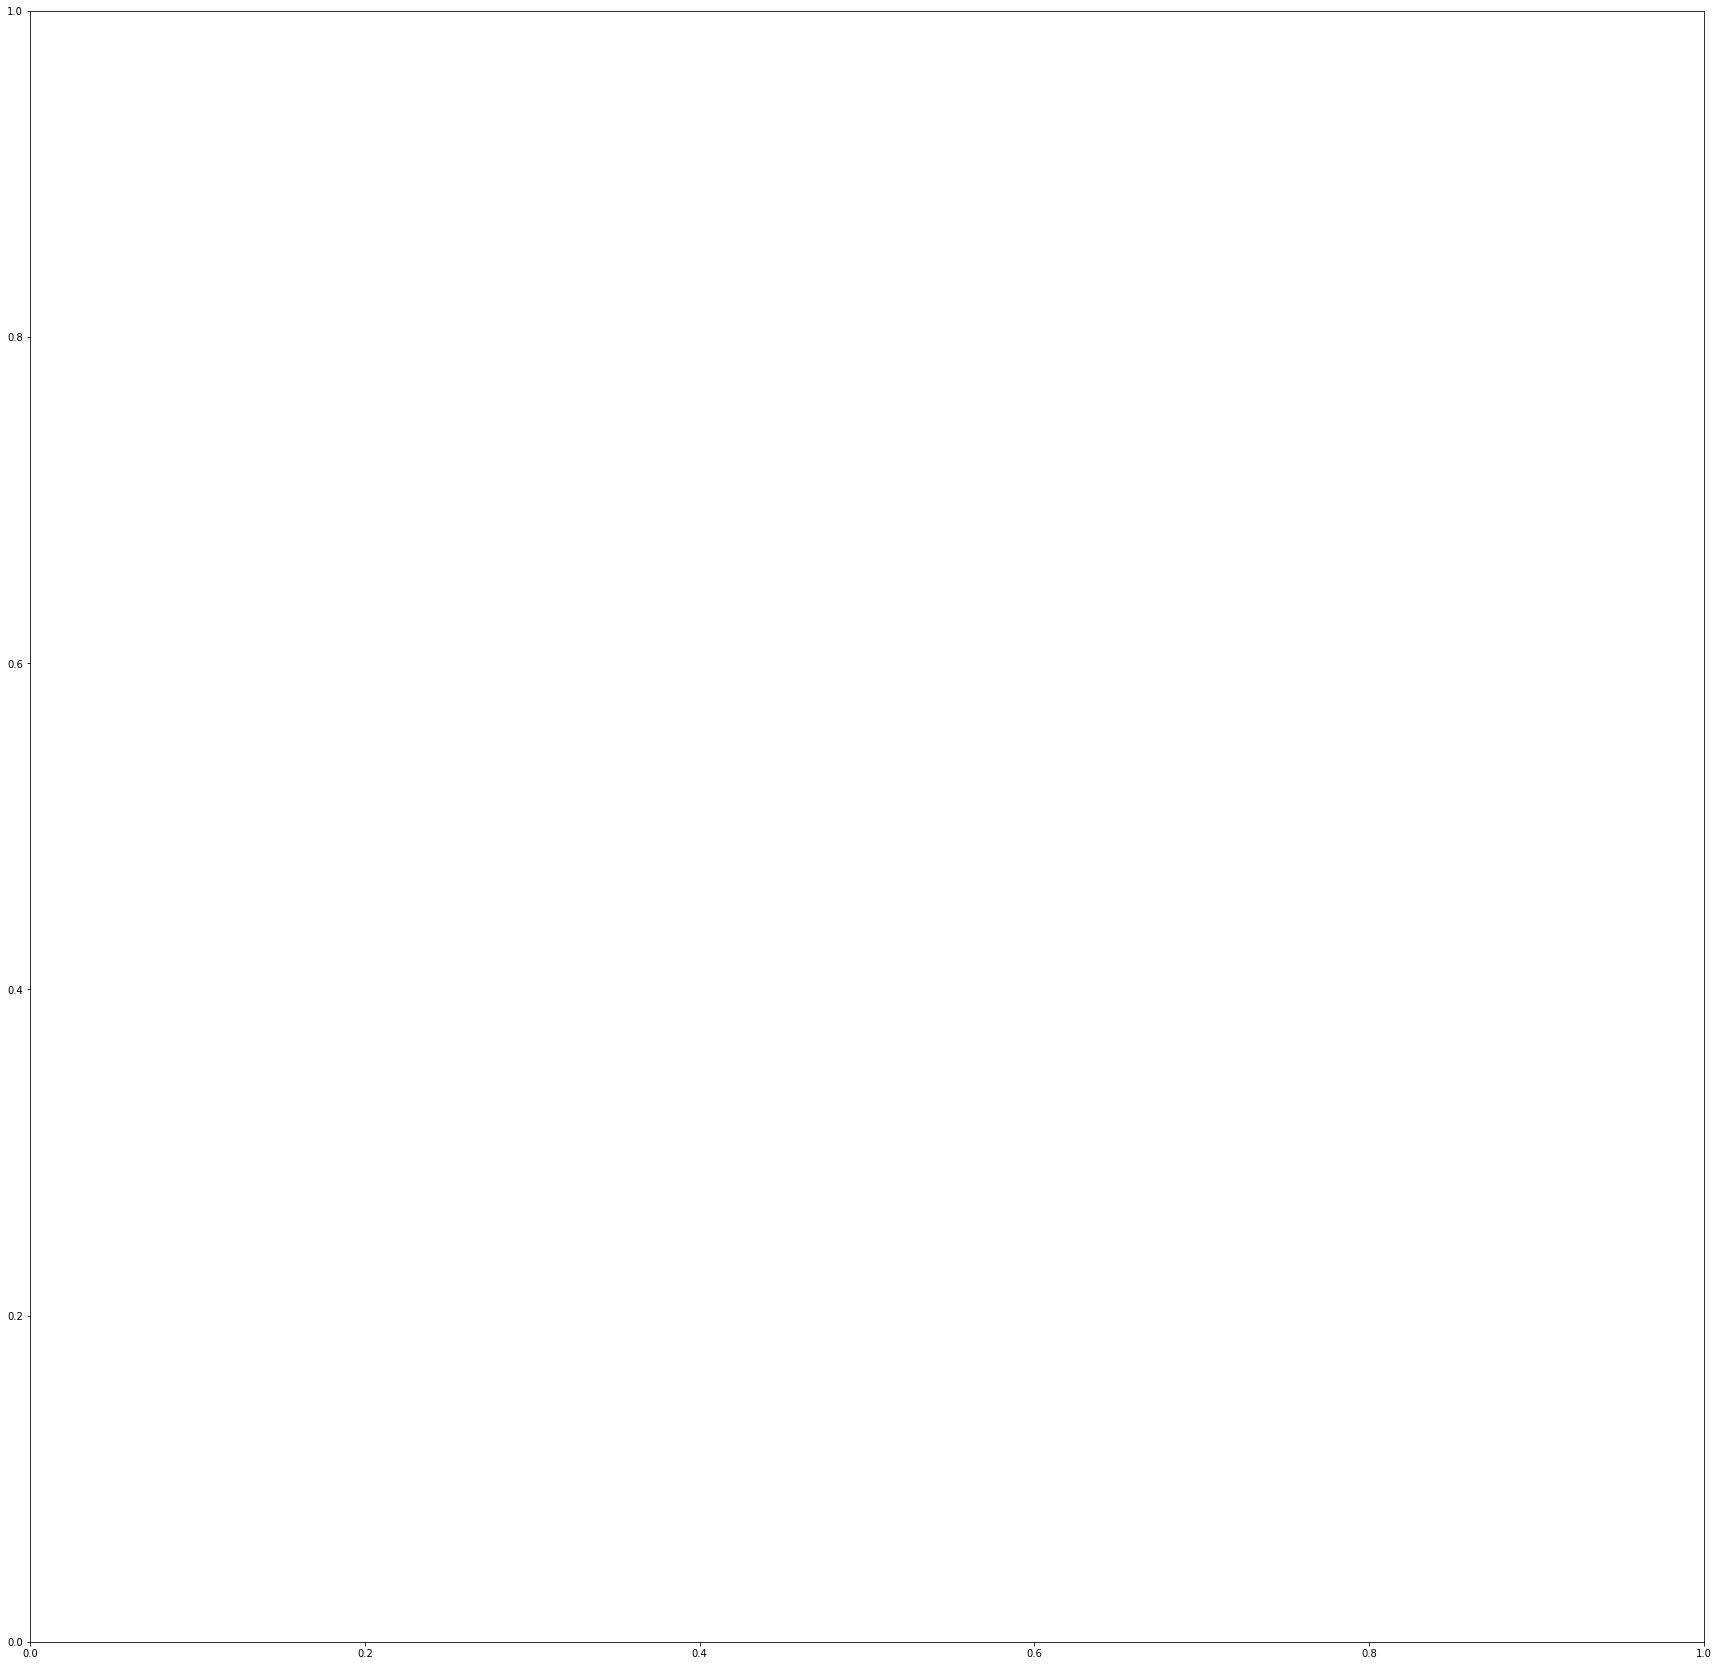

In [32]:
#Generate heatmap to show stat point correlation to overall rating
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(30, 30))
cf.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True).set_title("Correlation Heat Map", fontsize=50)
plt.savefig('output.png')

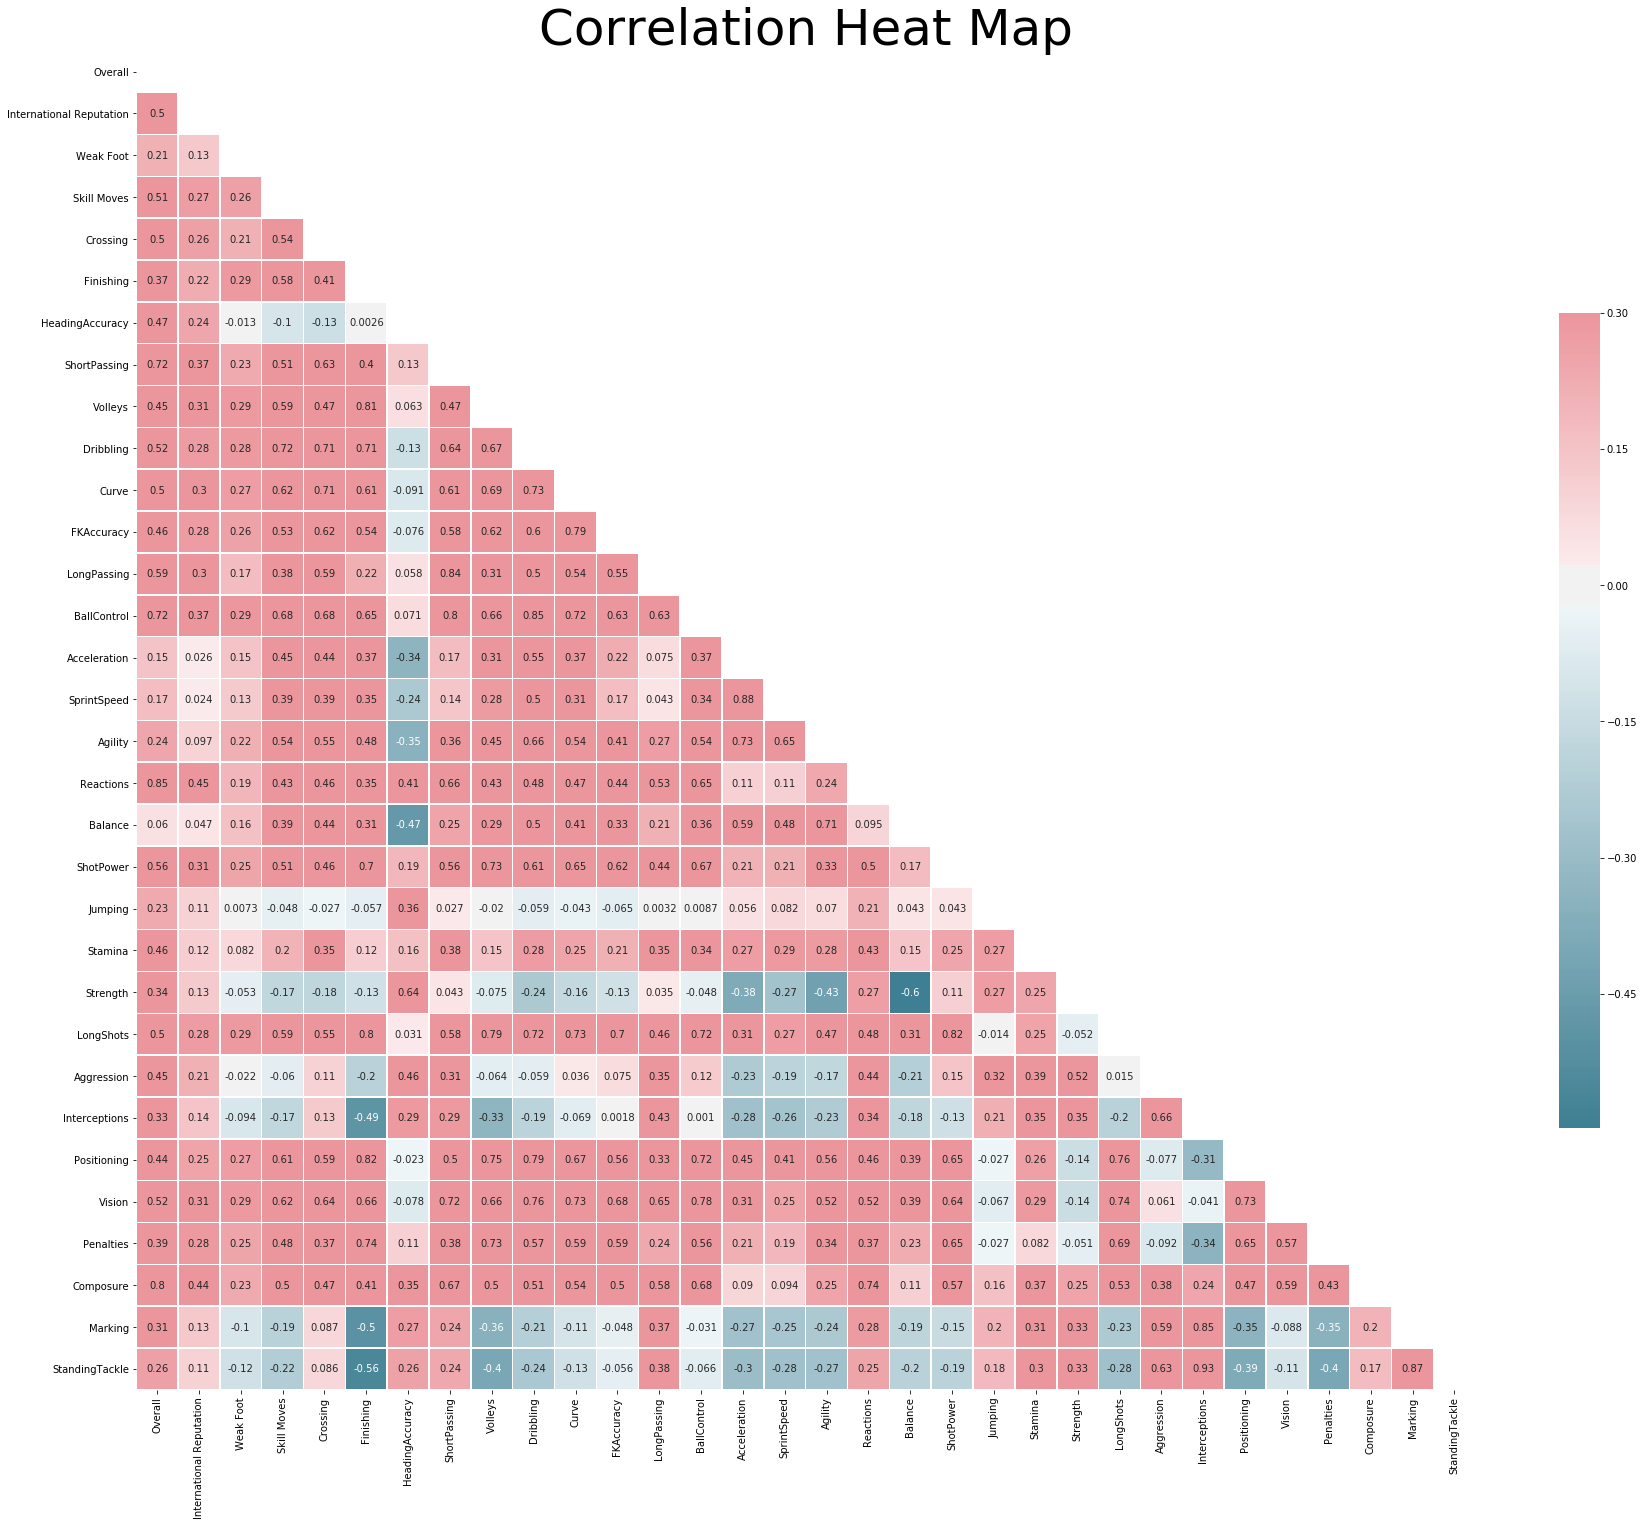

In [9]:
#Generate heatmap to show stat point correlation to overall rating
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True).set_title("Correlation Heat Map", fontsize=50)
plt.savefig('output.png')

### Attribute Boxplots

In [6]:
#Clean data to focus on stat points
df_subscore = df2.drop(columns=['Player ID', 'Name', 'Nationality', 'Overall'])
df_subscore.head()

KeyError: "['Player ID'] not found in axis"

In [88]:
#Create cufflinks boxplot
df_subscore.iplot(kind='box', filename='cufflinks/box-plots')

### Machine Learning
* Split dataset for machine training.
* Used SKLearn and XGBoost libraries to calculate r-squared value and mean squared error value.
* Used nonlinear regression to predict player rating based on skill points.

In [94]:
#Split data into testing and training sample sizes for machine learning
import cufflinks as cf
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')
X = df2.iloc[:,4:-1]
y = df2.loc[:,'Overall'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3)
print ("Train dataset sample size: %i" % len(X_train))
print ("Test dataset sample size: %i" % len(X_test))

Train dataset sample size: 4102
Test dataset sample size: 1758


In [95]:
#Evaluate R-squared and mean squared error
regbgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=1000,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

regbgb.fit(X_train,y_train)
p = regbgb.predict(X_test)
r2 = r2_score(y_test, p)
err = mean_squared_error(y_test, p)

print ( 'r2', r2)
print ( 'err', err)

r2 0.9730317488178916
err 1.3222655376482135


In [98]:
#Show machine predicted value compared to actual value
df1 = pd.DataFrame({'Predicted Test': p,'Actual Test': y_test}, index= X_test.index).sort_index()
df2 = df.iloc[X_test.index].sort_index()
df3 = pd.merge(df1, df2, left_index=True, right_index=True)
df3['difference'] = df3['Actual Test'] - df3['Predicted Test']
nationality = df3.Nationality.unique()
df3.sort_index(inplace=True)
for i in nationality:
    df3[df3['Nationality'] == i][['Predicted Test','Actual Test']].iplot(kind='scatter', xTitle='Player ID', yTitle='Overall Value',title= i, world_readable=True)

### Weight
* Assigned weights to stat points based on how much it affects overall rating

In [92]:
#Find which stat points most affect the overall rating
weights = pd.Series(100*regbgb.feature_importances_,index=X_train.columns).sort_values()
weights.iplot(kind='bar', yTitle='%', world_readable=True, title='Stat Point Weight')